In [7]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
# from catboost import CatBoostClassifier, CatBoostRegressort
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

### Посмотрим, что можно вытащить из данных. Пока рассмотрим 2017 год 

In [138]:
clothes_2017 = './clothes/2017/2017.xlsx'
data = pd.read_excel(clothes_2017,
                     header=2)
data.drop('НДС', axis=1, inplace=True)
data.head()

,Номер,Дата,Магазин,Артикул,ЦветРазмер,Штрихкод,Количество,Сумма,Сезон
0,0РRM-000001,01.01.2017 15:39:37,M_KHIMKI,531231,"6560, 134",6416134473773,-1.0,-3900.0,AW16
1,0РRM-000002,01.01.2017 15:50:44,M_KHIMKI,520178,"4908, 104",6416134458633,-1.0,-4950.0,AW16
2,0РTS-000001,01.01.2017 15:53:38,M_TEPLYST,518379,"6980, 036",6416134507973,-1.0,-1359.0,AW16
3,0РRM-000003,01.01.2017 16:58:38,M_KHIMKI,520178,"4908, 116",6416134458657,-1.0,-4950.0,AW16
4,0РTS-000002,01.01.2017 17:40:00,M_TEPLYST,520187B,"8439, 128",6416134460575,-1.0,-4500.0,AW16


In [139]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175569 entries, 0 to 175568
Data columns (total 9 columns):
Номер         175569 non-null object
Дата          175569 non-null object
Магазин       175569 non-null object
Артикул       175532 non-null object
ЦветРазмер    175532 non-null object
Штрихкод      174186 non-null object
Количество    175568 non-null float64
Сумма         175568 non-null float64
Сезон         175099 non-null object
dtypes: float64(2), object(7)
memory usage: 12.1+ MB


у нас тут много пробелов в данных, так что посмотрим сначала на урезанную выборку

In [140]:
data[[(type(x) != str) for x in data['Сезон']]]

,Номер,Дата,Магазин,Артикул,ЦветРазмер,Штрихкод,Количество,Сумма,Сезон
5031,0Р0V-000011,11.01.2017 22:06:50,VNUKOVO,531170,"4670, 146",6420024900881,1.0,4796.55,NaN
7673,0Р0V-000018,18.01.2017 22:13:47,VNUKOVO,531170,"4670, 152",6420024900898,1.0,5049.00,NaN
7857,0Р0V-000049,19.01.2017 12:49:43,VNUKOVO,531170,"4670, 152",6420024900898,-1.0,-5049.00,NaN
10960,0Р0V-000028,27.01.2017 22:03:52,VNUKOVO,531170,"4670, 152",6420024900898,1.0,4695.57,NaN
16380,0Р0V-000039,07.02.2017 22:01:40,VNUKOVO,526183B,"6516, 134",6420024713191,1.0,1099.00,NaN
17691,0Р0V-000043,11.02.2017 22:14:07,VNUKOVO,531170,"4670, 152",6420024900898,1.0,5937.82,NaN
22240,0Р0V-000055,23.02.2017 23:59:59,VNUKOVO,526183B,"6516, 110",6420024713153,1.0,1099.00,NaN
24011,0Р00-000049,28.02.2017 20:05:22,KRASNO,769074,"8442, 025",6420024715713,1.0,1007.83,NaN
25241,0Р0V-000063,03.03.2017 22:10:51,VNUKOVO,526183B,"9167, 098",6420024713221,1.0,1099.00,NaN
28582,0Р00-000059,10.03.2017 19:59:39,KRASNO,769074,"8442, 034",6420024715805,1.0,1039.00,NaN


In [141]:
data[[(x == 'OTHER') for x in data['Сезон']]]

,Номер,Дата,Магазин,Артикул,ЦветРазмер,Штрихкод,Количество,Сумма,Сезон
16,0РPU-000001,01.01.2017 21:00:49,PULKOVO,598321,"XXX, 000",6438088003141,1.0,199.00,OTHER
64,0РMD-000001,01.01.2017 22:00:07,M_DYBENKO,598321,"XXX, 000",6438088003141,1.0,199.00,OTHER
70,0РLR-000001,01.01.2017 22:00:09,CDM,598321,"XXX, 000",6438088003141,2.0,398.00,OTHER
135,0РRM-000001,01.01.2017 22:51:55,M_KHIMKI,598321,"XXX, 000",6438088003141,2.0,398.00,OTHER
148,0РTS-000001,01.01.2017 23:55:50,M_TEPLYST,598321,"XXX, 000",6438088003141,4.0,796.00,OTHER
236,0РPU-000002,02.01.2017 21:02:18,PULKOVO,598321,"XXX, 000",6438088003141,1.0,199.00,OTHER
273,0РLR-000002,02.01.2017 21:57:23,CDM,598321,"XXX, 000",6438088003141,4.0,796.00,OTHER
367,0Р0V-000002,02.01.2017 22:00:30,VNUKOVO,598321,"XXX, 0",NaN,1.0,199.00,OTHER
428,0Р0V-000002,02.01.2017 22:00:30,VNUKOVO,598321,"XXX, 000",6438088003141,1.0,199.00,OTHER
486,0РMD-000002,02.01.2017 22:01:14,M_DYBENKO,598321,"XXX, 000",6438088003141,1.0,199.00,OTHER


In [142]:
clean_data = data.dropna()
# clean_data['ЦветРазмер'] = clean_data['ЦветРазмер'].astype(str)
clean_data['Цвет'] = clean_data['ЦветРазмер'].apply(lambda x: x.split(',')[0])
clean_data['Размер'] = clean_data['ЦветРазмер'].apply(lambda x: x.split(',')[-1].strip())
clean_data.head()

,Номер,Дата,Магазин,Артикул,ЦветРазмер,Штрихкод,Количество,Сумма,Сезон,Цвет,Размер
0,0РRM-000001,01.01.2017 15:39:37,M_KHIMKI,531231,"6560, 134",6416134473773,-1.0,-3900.0,AW16,6560,134
1,0РRM-000002,01.01.2017 15:50:44,M_KHIMKI,520178,"4908, 104",6416134458633,-1.0,-4950.0,AW16,4908,104
2,0РTS-000001,01.01.2017 15:53:38,M_TEPLYST,518379,"6980, 036",6416134507973,-1.0,-1359.0,AW16,6980,036
3,0РRM-000003,01.01.2017 16:58:38,M_KHIMKI,520178,"4908, 116",6416134458657,-1.0,-4950.0,AW16,4908,116
4,0РTS-000002,01.01.2017 17:40:00,M_TEPLYST,520187B,"8439, 128",6416134460575,-1.0,-4500.0,AW16,8439,128


In [144]:
print(data.shape, clean_data.shape)
data.shape[0] - clean_data.shape[0]

(175569, 9) (173759, 11)


1810

In [145]:
names = {
    'Номер' : 'Number',
    'Дата' : 'Date',
    'Магазин' : 'Shop',
    'Артикул' : 'Vendor_code',
    'ЦветРазмер' : 'ColorSize',
    'Штрихкод' : 'Barcode',
    'Количество' : 'Quantity',
    'Сумма' : 'Amount',
    'Сезон' : 'Season',
    'Цвет' : 'Color',
    'Размер' : 'Size'
}
clean_data.rename(names, axis=1, inplace=True)
clean_data.head()

,Number,Date,Shop,Vendor_code,ColorSize,Barcode,Quantity,Amount,Season,Color,Size
0,0РRM-000001,01.01.2017 15:39:37,M_KHIMKI,531231,"6560, 134",6416134473773,-1.0,-3900.0,AW16,6560,134
1,0РRM-000002,01.01.2017 15:50:44,M_KHIMKI,520178,"4908, 104",6416134458633,-1.0,-4950.0,AW16,4908,104
2,0РTS-000001,01.01.2017 15:53:38,M_TEPLYST,518379,"6980, 036",6416134507973,-1.0,-1359.0,AW16,6980,036
3,0РRM-000003,01.01.2017 16:58:38,M_KHIMKI,520178,"4908, 116",6416134458657,-1.0,-4950.0,AW16,4908,116
4,0РTS-000002,01.01.2017 17:40:00,M_TEPLYST,520187B,"8439, 128",6416134460575,-1.0,-4500.0,AW16,8439,128


In [179]:
shops = clean_data['Shop'].unique()
seasons = clean_data['Season'].unique()
colors = clean_data['Color'].unique()

### Посмотрим, как продаются товары разных цветов

In [228]:
pos_quant = clean_data[clean_data['Quantity'] > 0].groupby('Color')[['Quantity']].agg(np.sum).reset_index()
neg_quant = clean_data[clean_data['Quantity'] < 0].groupby('Color')[['Quantity']].agg(np.sum).reset_index()
(pos_quant['Quantity'].argmax(), pos_quant['Quantity'].max()),\ # товаров с цветом '436' купили 22671 шт.
(neg_quant['Quantity'].argmin(),neg_quant['Quantity'].min()) # товаров с цветом '278' вернули 1038 шт.

((436, 22671.0), (278, -1038.0))

In [187]:
pos_amount = pd.DataFrame(clean_data[clean_data['Amount'] > 0].groupby('Color')[['Amount']].agg(np.sum)).reset_index()
neg_amount = pd.DataFrame(clean_data[clean_data['Amount'] < 0].groupby('Color')[['Amount']].agg(np.sum)).reset_index()
(pos_amount['Amount'].argmax(), pos_amount['Amount'].max()),\
(neg_amount['Amount'].argmin(),neg_amount['Amount'].min())

((436, 62271242.34000026), (278, -3303242.399999995))

In [188]:
pos_amount.head()

,Color,Amount
0,0100,1941351.29
1,0100A,68737.59
2,0101,25682.00
3,0102,292863.08
4,0104,65264.87


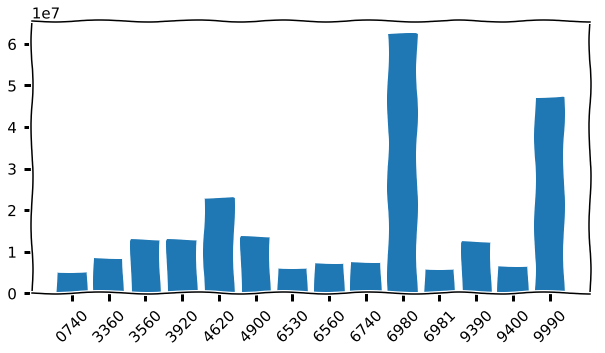

In [223]:
with plt.xkcd():
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=45)
    plt.bar(pos_amount[pos_amount['Amount'] > 5e6]['Color'],
            pos_amount[pos_amount['Amount'] > 5e6]['Amount']) # самые закупаемые товары по цветам

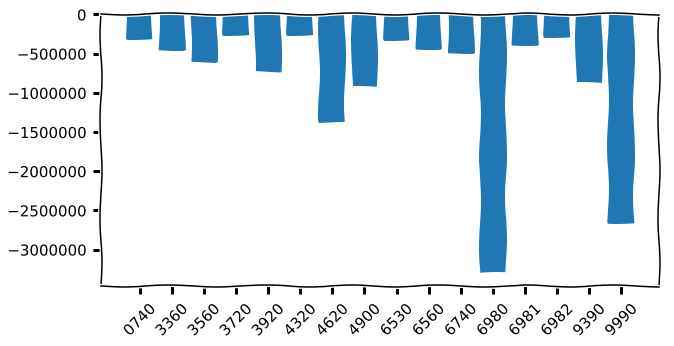

In [227]:
with plt.xkcd():
    plt.figure(figsize=(10,5))
    plt.xticks(rotation=45)
    plt.bar(neg_amount[neg_amount['Amount'] < -2.5e5]['Color'],
            neg_amount[neg_amount['Amount'] < -2.5e5]['Amount']) # самые возвращаемые товары по цветам

In [ ]:
# df = data['']

label encoder

In [ ]:
# label_encoder = LabelEncoder()

# for col in df.columns[df.dtypes == 'object']:
#     df[col] = label_encoder.fit_transform(df[col])

dummies, one-hot encoding

In [ ]:
# df = pd.get_dummies(df, columns=df.columns[df.dtypes == 'object']).drop('y', axis=1)

some plots

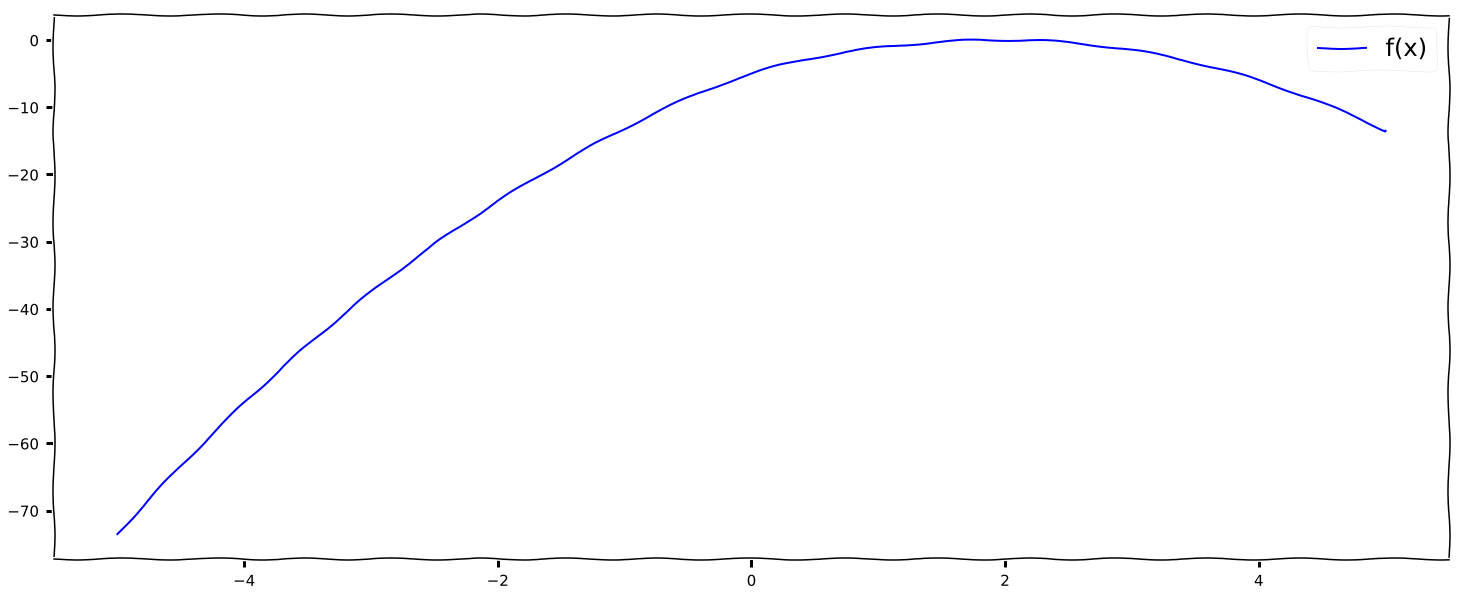

In [195]:
X = np.linspace(-5, 5, 500)
def f(x):
    return np.exp(-x**2) + 1.5*(-(x-2)**2)

with plt.xkcd():
    plt.figure(figsize=(25,10))
    plt.plot(X, f(X), lw=2, c='b', label='f(x)')
    plt.legend(fontsize='xx-large')

make hold out

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3,
#                                                     starify=y,
#                                                     random_state=17)

simple xgb

In [ ]:
# xgb_model = XGBClassifier(n_jobs=-1, random_state=17)

In [14]:
# xgb_model.fit(X, y)

# xgb.plot_importance(xgb_model)

cv